<a href="https://colab.research.google.com/github/SamuelLemosS/NTTGenIA/blob/main/Exerc%C3%ADcio_Aula_23_10_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarefas para criar um RAG
1. Carregar os dados
2. Criar coluna para representar cada review
3. Criar coluna com embeddings
4. Criar função para buscar reviews relevantes a partir de uma query de busca
5. Criar prompt para perguntar ao gpt
6. Enviar prompt para o gpt e mostrar as respostas

## 1. Carregar os dados

In [7]:
# fonte dos dados: https://www.kaggle.com/datasets/sergiogq/consumo-de-energia

import pandas as pd

df = pd.read_csv("Solar_On_City_Facilities.csv")

In [8]:
df.head()

,kW AC,Name,Year,Address
0,3.08,Southeast Austin Community Branch Library,01/01/2006 12:00:00 AM,"5803 Nuckolls Crossing\nAustin, Texas\n"
1,4.62,Far North Health Center,01/01/2008 12:00:00 AM,"928 Blackson Ave.\nAustin, Texas\n(30.333251, ..."
2,6.47,51st Street Water Tower / Fire Vehicle Mainten...,01/01/2010 12:00:00 AM,"2011 51st St E #B\nAustin, Texas\n(30.301443, ..."
3,77.00,Austin Bergstrom International Airport,01/01/1998 12:00:00 AM,"2716 Spirit of Texas Dr.\nAustin, Texas\n(30.2..."
4,3.08,Dove Springs Recreation Center,01/01/2006 12:00:00 AM,"5801 Ainez Dr.\nAustin, Texas\n(30.187717, -97..."


## 2. Criar coluna para representar cada review

In [28]:
df["kW AC"] = df["kW AC"].astype(str)
df["Name"] = df["Name"].astype(str)
df["Year"] = df["Year"].astype(str)
df["prompt_text"] = df["Name"] + " gerou " + df['kW AC'] + " de energia eletrica solar no ano " + df['Year']

## 3. Criar coluna com embeddings
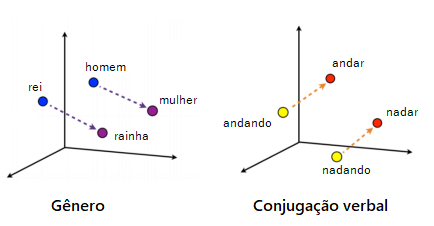

fonte: https://medium.com/turing-talks/word-embedding-fazendo-o-computador-entender-o-significado-das-palavras-92fe22745057

In [3]:
!pip install python-dotenv

In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [6]:
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

os.environ["OPENAI_API_KEY"]
os.environ['OPENAI_API_BASE']

'https://openai-portodigital.openai.azure.com/'

In [10]:
import openai

openai.api_type = "azure"
openai.api_key  = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ['OPENAI_API_BASE']
openai.api_version = "2023-05-15"

response = openai.Embedding.create(
    input="OI BRASIL",
    engine="text-similarity-ada-001"
)

In [11]:
embeddings = response['data'][0]['embedding']
embeddings

[-0.019395481795072556,
 0.030103718861937523,
 -0.0001273331290576607,
 0.032396186143159866,
 0.02742917463183403,
 -0.0012279280927032232,
 0.02847486175596714,
 -0.013141470029950142,
 0.050112538039684296,
 -0.026041626930236816,
 0.00418526167050004,
 -0.026262830942869186,
 0.03752407431602478,
 -0.019174279645085335,
 -0.008516316302120686,
 -0.031229844316840172,
 -0.021336035802960396,
 -0.007430410478264093,
 -0.004117392469197512,
 -0.01598694548010826,
 0.043154697865247726,
 -0.013915680348873138,
 0.028434641659259796,
 -0.00904921442270279,
 -0.020421059802174568,
 0.018420178443193436,
 -0.031873345375061035,
 0.0047282143495976925,
 -0.01569535955786705,
 -0.01875198259949684,
 -0.04987122491002083,
 0.015946727246046066,
 0.0006541828042827547,
 0.06603915244340897,
 0.03975621610879898,
 -0.02026018500328064,
 -0.04027905687689781,
 -0.011854470707476139,
 0.011502556502819061,
 0.01390562579035759,
 -0.045608039945364,
 -0.00938604585826397,
 0.001997111365199089,


## 4. Criar função para buscar reviews relevantes a partir de uma query de busca

In [12]:
import openai
import time

def text_embedding(text):
    """
    Recebe string, faz chamada ao modelo de embeddings da openai e retorna os embeddings da string
    """
    response = None
    retry_count = 0

    while response is None:
        try:
            response = openai.Embedding.create(engine="text-similarity-ada-001", input=text)
        except Exception as e:
            # Verifique se o erro é devido ao limite de chamadas
            if "call rate limit" in str(e):
                # Espere por um tempo exponencialmente crescente antes de tentar novamente
                time.sleep(2 ** retry_count)
                retry_count += 1
                continue
            else:
                # Se ocorrer outro tipo de erro, lide com ele de acordo com sua lógica de tratamento de erros
                print("Erro ao fazer chamada para a API: ", str(e))
                return None

    return response["data"][0]["embedding"]

In [20]:
# Cria sample das linhas para fazer menos chamadas ao modelo
df_menor = df.sample(50)

In [21]:
df_menor.shape

(50, 5)

In [29]:
# criar coluna com os embeddings
df_menor["embeddings"] = df_menor["prompt_text"].apply(lambda linha: text_embedding(linha))

In [23]:
df_menor = df_menor.dropna(subset="embeddings", axis=0)

In [31]:
from scipy import spatial

def strings_ranked_by_relatedness(
    query: str,
    df: pd.DataFrame,
    relatedness_fn=lambda x, y: 1 - spatial.distance.cosine(x, y),
    top_n: int = 10
) -> tuple[list[str], list[float]]:
    """
    Retorna as linhas do dataframe mais semelhantes a string de busca
    """

    query_embedding = text_embedding(query)

    strings_and_relatednesses = [ ]
    for i, row in df.iterrows():

        #relatedness = relatedness_fn(np.array(query_embedding).flatten(), np.array(row["embedding"]).flatten())
        relatedness = relatedness_fn(query_embedding, row["embeddings"])
        item = (row["prompt_text"], relatedness)
        strings_and_relatednesses.append(item)

    strings_and_relatednesses.sort(key=lambda x: x[1], reverse=True)
    strings, relatednesses = zip(*strings_and_relatednesses)
    return strings[:top_n], relatednesses[:top_n]

In [32]:
strings, relatednesses = strings_ranked_by_relatedness("Alguém gerou mais de 100kw ac antes do ano de 2020? Se o valor for superior e posterior a 2020 não o mostre",
                              df_menor)
for string, relatedness in zip(strings, relatednesses):
    print(f"{relatedness=:.3f}")
    display(string)

relatedness=0.858


'Decker PV300 gerou 230.63 de energia eletrica solar no ano 11/01/2013 12:00:00 AM'

relatedness=0.854


'System Control Center gerou 403.17 de energia eletrica solar no ano 11/01/2013 12:00:00 AM'

relatedness=0.852


'Yellowbike Project gerou 10.61 de energia eletrica solar no ano 11/01/2012 12:00:00 AM'

relatedness=0.852


'DittmarSolar Tree gerou 1.54 de energia eletrica solar no ano 01/01/2010 12:00:00 AM'

relatedness=0.851


'Gus Garcia gerou 60.74 de energia eletrica solar no ano 11/01/2013 12:00:00 AM'

relatedness=0.850


'ARCH Shelter gerou 2.77 de energia eletrica solar no ano 01/01/2004 12:00:00 AM'

relatedness=0.850


'Givens Rec Center gerou 4.0 de energia eletrica solar no ano 11/01/2012 12:00:00 AM'

relatedness=0.848


'Carver Library gerou 50.45 de energia eletrica solar no ano 11/01/2012 12:00:00 AM'

relatedness=0.847


'ABIA GTSA gerou 67.76 de energia eletrica solar no ano 11/01/2012 12:00:00 AM'

relatedness=0.847


'Glen Bell Service Center gerou 104.72 de energia eletrica solar no ano 11/01/2010 12:00:00 AM'

## 5. Criar prompt para perguntar ao gpt
* O modelo possui um limite de tokens, vamos verificar se o limite foi atingido ou não para criar o prompt

In [33]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


In [34]:
import tiktoken

def num_tokens(text: str) -> int:
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")
    return len(encoding.encode(text))

In [35]:
num_tokens("oi brasil")

3

In [36]:
num_tokens("Alguém gerou mais de 100kw ac antes do ano de 2020?")

19

In [37]:
def montar_query(query: str, df: pd.DataFrame, token_budget: int) -> str:
    linhas, relatednesses = strings_ranked_by_relatedness(query, df)
    introducao = """
    Use o conteúdo abaixo com reviews de jogos para responder a pergunta a seguir.
    O conteúdo das reviews deve ser a sua única fonte para dar as respostas.
    Se você não conseguir encontrar a resposta no conteúdo, escreva "Não consegui encontrar uma resposta."
    """
    pergunta = f"\n\Pergunta: {query}"
    messagem = introducao
    for linha in linhas:
        proxima_linha = f'\n\nSeção com dados da gerecao de nergia solar:\n"""\n{linha}\n"""'
        if num_tokens(messagem + proxima_linha + pergunta) > token_budget:
            break
        else:
            messagem = messagem + proxima_linha

    return messagem + pergunta


In [38]:
from pprint import pprint

prompt = montar_query(query="Alguém gerou mais de 100kw ac antes do ano de 2020?",
             df=df_menor,
             token_budget=16000)
pprint(prompt)

('\n'
 '    Use o conteúdo abaixo com reviews de jogos para responder a pergunta a '
 'seguir.\n'
 '    O conteúdo das reviews deve ser a sua única fonte para dar as '
 'respostas.\n'
 '    Se você não conseguir encontrar a resposta no conteúdo, escreva "Não '
 'consegui encontrar uma resposta."\n'
 '    \n'
 '\n'
 'Seção com dados da gerecao de nergia solar:\n'
 '"""\n'
 'Decker PV300 gerou 230.63 de energia eletrica solar no ano 11/01/2013 '
 '12:00:00 AM\n'
 '"""\n'
 '\n'
 'Seção com dados da gerecao de nergia solar:\n'
 '"""\n'
 'Givens Rec Center gerou 4.0 de energia eletrica solar no ano 11/01/2012 '
 '12:00:00 AM\n'
 '"""\n'
 '\n'
 'Seção com dados da gerecao de nergia solar:\n'
 '"""\n'
 'Gus Garcia gerou 60.74 de energia eletrica solar no ano 11/01/2013 12:00:00 '
 'AM\n'
 '"""\n'
 '\n'
 'Seção com dados da gerecao de nergia solar:\n'
 '"""\n'
 'System Control Center gerou 403.17 de energia eletrica solar no ano '
 '11/01/2013 12:00:00 AM\n'
 '"""\n'
 '\n'
 'Seção com dados da

## 6. Enviar prompt para o gpt e mostrar as respostas

In [39]:
def perguntar(
    query: str,
    df: pd.DataFrame = df,
    model: str = "gpt-35-turbo-16k",
    print_message: bool = False,
) -> str:
    message = montar_query(query, df, token_budget=16000)
    if print_message:
        print(message)
    messages = [
        {"role": "system", "content": "Você responde perguntas sobre a energia gerada por paneis solares."},
        {"role": "user", "content": message},
    ]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0,
        engine="gpt-35-turbo-16k"
    )
    response_message = response["choices"][0]["message"]["content"]
    return response_message

In [40]:
resposta = perguntar("Alguém gerou mais de 100kw ac depois do ano de 2020?",
    df_menor)
print(resposta)

Não consegui encontrar uma resposta.
